In [ ]:
# from
# https://github.com/yashy3nugu/Anime-Face-GAN/blob/main/DCGAN.ipynb

In [46]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [47]:
class save_images(keras.callbacks.Callback):
    """
    This is a subclass of the keras.callbacks.Callback class.
    On subclassing it we can specify methods which can be executed while training
    """

    def __init__(self,noise,margin,num_rows,num_cols,**kwargs):
        super(keras.callbacks.Callback,self).__init__(**kwargs)
        self.noise = noise
        self.margin = margin
        self.num_rows = num_rows
        self.num_cols = num_cols

    # overwriting on_epoch_end() helps in executing a custom method when an epoch ends
    def on_epoch_end(self, epoch, logs=None):
        """
        Saves images generated from a fixed random vector by the generator to the disk 
        
        Parameters:
            noise: fixed noise vector from a normal distribution to be fed to the generator.
            num_rows: number of rows of images
            num_cols: number of columns of images
            margin: margin between images
            generator: keras model representing the generator network
        
        """

        # Generate a base array upon which images can then be added sequentially
        image_array = np.full((
            self.margin + (self.num_rows * (64 + self.margin)),
            self.margin + (self.num_cols * (64 + self.margin)), 3),
            255, dtype=np.uint8)

        # Generate num_rows*num_cols number of images using the generator model
        generated_images = self.model.generator.predict(self.noise)

        # Convert pixel intensities to the range [0,1]
        generated_images = 0.5 * generated_images + 0.5

        #Images need not be converted into the typical [0,255] pixel intensity values because the PIL Image module accepts the range [0,1] 


        image_count = 0
        for row in range(self.num_rows):
            for col in range(self.num_cols):
                r = row * (64 + 16) + self.margin
                c = col * (64 + 16) + self.margin
                image_array[r:r + 64, c:c + 64] = generated_images[image_count] * 255
                image_count += 1

        # The image array now contains all the images in an array format which can be stored to the disk

        output_path = 'Epoch_images'
        if not os.path.exists(output_path):
            os.makedirs(output_path)

        filename = os.path.join(output_path, f"train-{epoch+1}.png")
        im = Image.fromarray(image_array)
        im.save(filename)


class checkpoint_callback(keras.callbacks.Callback):
    """
    Subclass of keras.callbacks.Callback to save the weights every epoch in a .h5 file
    """
    def __init__(self,**kwargs):
        super(keras.callbacks.Callback, self).__init__(**kwargs)
    def on_epoch_end(self, epoch, logs=None):
        
        output_path = 'Weights'
        if not os.path.exists(output_path):
            os.makedirs(output_path)

        self.model.generator.save_weights("Weights/generator_weights-test.h5")
        self.model.discriminator.save_weights("Weights/discriminator_weights-test.h5")

---

In [48]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU , ReLU, PReLU
from tensorflow.keras.layers import Conv2D ,Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
import os 
import matplotlib.pyplot as plt

In [49]:
# Configure tensorflow to only use the gpu (Run this only when you want to train on GPU)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("using GPU")
    except RuntimeError as e:
        print(e)

using GPU


In [54]:
data_path = "images/"

In [55]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, 
    label_mode=None, 
    color_mode='rgb',
    batch_size=128,
    image_size=(64, 64),
    shuffle=True
)

train_ds = train_ds.map(lambda x: ((x/127.5)-1)) 

Found 63565 files belonging to 1 classes.
tf.Tensor(
[[[[251.84985  255.       250.84985 ]
   [250.52856  255.       249.99731 ]
   [251.1272   254.90845  252.1272  ]
   ...
   [254.3601   254.3601   252.3601  ]
   [254.       254.76562  254.29688 ]
   [254.       255.       255.      ]]

  [[252.40894  255.       250.94019 ]
   [251.82764  255.       250.82764 ]
   [250.28125  253.64502  250.8125  ]
   ...
   [254.09155  254.23438  252.23438 ]
   [254.       254.82056  254.3518  ]
   [254.       255.       255.      ]]

  [[254.       255.       251.      ]
   [253.76562  255.       251.23438 ]
   [251.35205  253.35205  250.35205 ]
   ...
   [254.23804  255.       253.      ]
   [254.       255.       254.53125 ]
   [254.       255.       255.      ]]

  ...

  [[175.1101   143.89209  116.07886 ]
   [191.10156  160.40503  128.72876 ]
   [200.95972  170.99829  132.69312 ]
   ...
   [158.09448  139.16064  135.2461  ]
   [241.72485  231.57983  228.26953 ]
   [255.       248.9851   245.60

tf.Tensor(
[[[[253.76465  239.62622  243.49707 ]
   [226.51099  195.18506  199.18506 ]
   [231.45752  173.6919   176.09814 ]
   ...
   [250.8396   132.42334  126.29834 ]
   [241.11548  126.240234 137.50903 ]
   [201.04663  115.11743  134.4497  ]]

  [[226.469    194.39648  198.13403 ]
   [239.42651  182.51685  188.12012 ]
   [143.10107   85.59888   85.676025]
   ...
   [247.65503  125.77759  116.371826]
   [253.93677  131.80762  138.79199 ]
   [222.73291  116.57031  131.77026 ]]

  [[165.1726   127.72412  121.19287 ]
   [226.6748   190.84204  184.04468 ]
   [251.57544  224.08398  218.49341 ]
   ...
   [252.56177  136.01294  119.37109 ]
   [251.29468  123.340576 121.18384 ]
   [241.8269   125.92578  131.26953 ]]

  ...

  [[200.67603  211.09253  238.66553 ]
   [197.4707   210.45483  247.40771 ]
   [194.78125  207.57812  252.86377 ]
   ...
   [166.84033   51.42163   77.94849 ]
   [154.4624    42.28784   67.42969 ]
   [157.552     57.342773  78.55664 ]]

  [[201.61865  211.74072  250.6374

tf.Tensor(
[[[[255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   ...
   [253.88574  255.       254.88574 ]
   [254.84375  255.       255.      ]
   [254.       254.       254.      ]]

  [[255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   ...
   [251.96484  253.43652  252.87207 ]
   [252.3125   254.28809  253.3125  ]
   [253.8877   254.15625  254.04395 ]]

  [[255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   ...
   [254.35254  254.51758  254.51758 ]
   [252.40527  254.15625  253.3125  ]
   [253.       255.       254.      ]]

  ...

  [[254.70801  254.70801  254.70801 ]
   [253.59375  255.       254.28125 ]
   [253.59375  254.16504  252.      ]
   ...
   [ 30.42871   30.42871   32.42871 ]
   [ 29.719727  29.719727  31.719727]
   [ 47.311523  46.499023  48.905273]]

  [[254.15625  254.15625  254.1562

tf.Tensor(
[[[[ 36.34021    45.109863   50.225037 ]
   [ 80.08246    89.08246    94.08246  ]
   [ 86.76758    95.76758   100.76758  ]
   ...
   [252.31909   254.73541   254.64722  ]
   [254.        255.        255.       ]
   [253.24799   255.        254.24799  ]]

  [[ 72.013      78.48175    84.401855 ]
   [ 94.00781   102.52844   107.76813  ]
   [ 88.546814   97.546814  102.546814 ]
   ...
   [251.07397   253.80157   253.4021   ]
   [254.        255.        255.       ]
   [252.2724    253.61792   253.2724   ]]

  [[ 95.58557   100.674805  106.674805 ]
   [ 97.270325  103.739075  109.605225 ]
   [ 81.72388    90.27771    95.50079  ]
   ...
   [252.67188   255.        255.       ]
   [254.        255.        255.       ]
   [250.23993   252.10712   251.23993  ]]

  ...

  [[ 19.379517   28.379517   35.379517 ]
   [ 12.806763   21.009888   28.408325 ]
   [ 10.5512085  17.551208   25.551208 ]
   ...
   [ 11.302063   20.302063   25.302063 ]
   [ 21.706787   30.706787   35.706787 ]
   [ 

tf.Tensor(
[[[[2.55000000e+02 2.53816467e+02 2.54816467e+02]
   [2.53722839e+02 2.54519348e+02 2.54242188e+02]
   [2.51344360e+02 2.55000000e+02 2.53820312e+02]
   ...
   [1.06492004e+02 1.16124817e+02 1.14913879e+02]
   [2.52546875e+02 2.55000000e+02 2.55000000e+02]
   [2.54757812e+02 2.55000000e+02 2.55000000e+02]]

  [[2.55000000e+02 2.54726562e+02 2.55000000e+02]
   [2.54801331e+02 2.54925232e+02 2.55000000e+02]
   [2.52995178e+02 2.54846741e+02 2.53851562e+02]
   ...
   [1.51796509e+02 1.62002625e+02 1.60791687e+02]
   [2.52018982e+02 2.55000000e+02 2.55000000e+02]
   [2.54757812e+02 2.54449402e+02 2.55000000e+02]]

  [[2.52891235e+02 2.55000000e+02 2.54210938e+02]
   [2.53937500e+02 2.54426697e+02 2.54210938e+02]
   [2.54210938e+02 2.54044495e+02 2.53789062e+02]
   ...
   [2.06412720e+02 2.19589355e+02 2.17211975e+02]
   [2.43574768e+02 2.50113831e+02 2.49387268e+02]
   [2.53545044e+02 2.54744568e+02 2.54584717e+02]]

  ...

  [[2.54402039e+02 2.54402039e+02 2.54402039e+02]
   [2

tf.Tensor(
[[[[142.       144.       143.      ]
   [134.6875   138.3125   137.3125  ]
   [143.3125   148.6875   147.      ]
   ...
   [123.25     134.25     130.25    ]
   [170.875    181.875    177.875   ]
   [127.       138.       134.      ]]

  [[137.9375   139.9375   138.9375  ]
   [179.47656  183.10156  182.10156 ]
   [197.69922  203.07422  201.38672 ]
   ...
   [102.9375   113.9375   109.9375  ]
   [139.59375  150.59375  146.59375 ]
   [164.375    175.375    171.375   ]]

  [[200.9375   201.5625   201.25    ]
   [213.53125  215.78125  214.91016 ]
   [218.07031  222.07031  220.85547 ]
   ...
   [ 93.265625 104.265625 100.265625]
   [113.72656  124.72656  120.72656 ]
   [168.875    179.875    175.875   ]]

  ...

  [[254.3125   255.       253.      ]
   [252.6875   253.9336   251.375   ]
   [253.       253.64453  251.42969 ]
   ...
   [182.4961   184.1836   184.1211  ]
   [206.70703  208.39453  208.33203 ]
   [221.6875   223.375    223.3125  ]]

  [[254.8125   254.8125   252.8125

tf.Tensor(
[[[[253.64954    255.         251.45312   ]
   [252.14514    255.         254.35938   ]
   [250.96613    253.34113    253.08447   ]
   ...
   [148.81305    111.65015     93.97046   ]
   [153.74707    116.221375   107.54169   ]
   [150.00897    113.00897    105.00897   ]]

  [[254.5257     255.         251.45312   ]
   [252.64062    254.53802    253.43542   ]
   [251.74396    251.53479    249.81256   ]
   ...
   [157.74237    119.79706    107.06268   ]
   [134.37762     97.377625    88.480225  ]
   [153.81409    116.81409    108.1344    ]]

  [[255.         255.         251.        ]
   [252.05292    252.05292    249.23175   ]
   [251.75336    246.62836    243.57544   ]
   ...
   [143.94928    106.666016    98.36536   ]
   [146.46625    109.59387    100.6416    ]
   [130.62085     93.81384     84.475586  ]]

  ...

  [[252.45312    255.         253.        ]
   [254.67969    255.         253.        ]
   [255.         254.13281    253.        ]
   ...
   [172.94098    172.923

tf.Tensor(
[[[[143.59259    12.375366   23.297241 ]
   [150.45685    25.14569    36.409973 ]
   [122.34033    10.286377   23.130676 ]
   ...
   [192.97473   149.87115    90.03467  ]
   [119.4151     93.94501    60.663208 ]
   [247.44757   247.53387   235.69281  ]]

  [[122.73633     9.148499   18.251953 ]
   [117.86664    12.042114   20.815063 ]
   [101.61426    12.076599   19.52533  ]
   ...
   [160.75403   107.3786     66.28937  ]
   [ 78.30975    41.44281    20.931702 ]
   [219.20117   219.20929   206.44336  ]]

  [[107.83191    25.027039   33.167297 ]
   [ 76.98486     6.3934937  11.366211 ]
   [ 48.69458     1.4877319   1.7547607]
   ...
   [ 89.36566    21.671265   12.133179 ]
   [ 76.42749    19.575928   19.97052  ]
   [193.73016   187.19836   179.15875  ]]

  ...

  [[243.08588   120.84387   132.46124  ]
   [255.        142.33661   154.93872  ]
   [252.88055   147.19946   160.92786  ]
   ...
   [119.84656    15.823547   22.766113 ]
   [116.517395    1.9921875   9.277405 ]
   [1

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [52]:
# Weights initializer
init = tf.keras.initializers.RandomNormal(stddev=0.02)

In [7]:
def build_generator(seed_size):
    """
    Builds the generator model
    
    Parameters:
        seed_size: size of the random vector fed into the generator
    
    Returns:
        model: keras model representing the generator
    """
    model = Sequential()
  
    # Block - 1
    model.add(Dense(4*4*1024,kernel_initializer=init,input_dim=seed_size))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Reshape((4,4,1024))) # Resulting shape = (4,4,1024) 

    # Block - 2
    model.add(Conv2DTranspose(512,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU())  # Resulting shape = (8,8,512)

    # Block - 3
    model.add(Conv2DTranspose(256,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU()) # Resulting shape = (16,16,256)

    # Block - 4
    model.add(Conv2DTranspose(128,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU()) # Resulting shape = (32,32,128)

    # Block - 5
    model.add(Conv2DTranspose(3,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(Activation('tanh')) # Resulting shape = (64,64,3)

    return model

In [8]:
def build_discriminator(image_length,image_channels):
    
    """
    Builds the generator model
    
    Parameters:
        image_length: length of a side of the square image
        image_channels: number of channels in the image
    
    Returns:
        model: keras model representing the discriminator
    """
    
    model = Sequential()
  
    # Block - 1
    model.add(Conv2D(64,kernel_size=3,strides=2,padding='same',use_bias=False,input_shape=(image_length,image_length,image_channels),kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2)) # Resulting shape = (32,32,64)

    # Block - 2
    model.add(Conv2D(128,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2)) # Resulting shape = (16,16,128)

    # Block - 3
    model.add(Conv2D(256,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2)) # Resulting shape = (8,8,256)

    # Block - 4
    model.add(Conv2D(512,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2)) # Resulting shape = (4,4,512)

    # Block - 5
    model.add(Conv2D(1,kernel_size=4,strides=1,padding='valid',use_bias=False,kernel_initializer=init))
    model.add(Flatten())
    model.add(Activation('sigmoid'))

    return model

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [10]:
class DCGAN(keras.Model):
    """Subclass of the keras.Model class to define custom training step and loss functions"""
    
    
    def __init__(self,seed_size,image_length,image_channels,**kwargs):
        """
        Parameters:
            seed_size: size of the random vector for the generator
            image_length: length of a side of the square image
            image_channels: number of channels in the image
        """
        super(DCGAN,self).__init__(**kwargs)

        self.generator = build_generator(seed_size)
        self.discriminator = build_discriminator(image_length,image_channels)
        self.seed_size = seed_size
        
        
   # Train generator to give realistic images and penalize it for giving images being classified as fake by the discriminator     
    def generator_loss(self,fake_output):
        """
        Parameters:
            fake_output: Tensor containing the respective discriminator's predictions for the batch of images produced
            by generator (fake iamges).
            
        Returns:
            cross entropy loss between labels for real images (1's) and the discriminator's estimate 
        """
        
        # The objective is to penalize the generator whenever it produces images which the discriminator classifies as 'fake'
        return cross_entropy(tf.ones_like(fake_output), fake_output)

       
        # smooth parameter is used to induce one sided label smoothing. It can be tuned accordingly
    def discriminator_loss(self,real_output, fake_output,smooth=0.1):
        """
        Parameters: 
            real_output: Tensor containing the respective discriminator's predictions for the batch of images taken from
                        the dataset (real images).
            fake_output: Tensor containing the respective discriminator's predictions for the batch of images produced
                        by generator (fake images).
        
        Returns:
            total_loss: Loss of the discriminator for misclassifying images
        """
        # label for real image is (1-smooth)
        real_loss = cross_entropy(tf.ones_like(real_output)*(1-smooth), real_output) 
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss
    
    def compile(self,generator_optimizer,discriminator_optimizer):
        """
        configures model for training by adding optimizers
        
        Parameters: 
            generator_optimizer: keras optimizer to be used to train generator.
            discriminator_optimizer: keras optimizer to be used to train discriminator.
        """
        super(DCGAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        
    @tf.function    
    def train_step(self,data):
        
        """
        Takes in training data and does a forward pass
        
        Parameters:
            data: a batch from the training data.
        Returns:
            gen_loss: loss associated with the generator.
            disc_loss: loss associated with the discriminator.
            
        """
            
        batch_size = tf.shape(data)[0]
        
        # feed a random input to generator
        seed = tf.random.normal(shape=(batch_size,self.seed_size))
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            
            # generate image using generator
            generated_image = self.generator(seed, training = True)
        
            # discriminator's prediction for real image
            real_output = self.discriminator(data,training = True)
            
            # discriminator's estimate for fake image
            fake_output = self.discriminator(generated_image,training = True) 
            
            # compute loss
            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output,fake_output)

            # optimize generator first
            generator_grad = gen_tape.gradient(gen_loss,self.generator.trainable_variables)
            discriminator_grad = disc_tape.gradient(disc_loss,self.discriminator.trainable_variables)

            # optimize discriminator after generator
            self.generator_optimizer.apply_gradients(zip(generator_grad,self.generator.trainable_variables))
            self.discriminator_optimizer.apply_gradients(zip(discriminator_grad,self.discriminator.trainable_variables))
        
        return {
            "generator loss": gen_loss,
            "discriminator_loss": disc_loss
        }

In [11]:
# parameters and hyperparameters
image_length = 64
image_channels = 3
batch_size = 128
seed_size = 128

NUM_ROWS = 4  
NUM_COLS = 7
MARGIN = 16

fixed_seed = tf.random.normal(shape=(NUM_ROWS * NUM_COLS, seed_size))
# We are defining a fixed seed because we want to see the generator's images quality by generating the same images every epoch

In [12]:
generator_optimizer = Adam(learning_rate=0.0002,beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.0002,beta_1=0.5)

dcgan = DCGAN(seed_size,image_length,image_channels)
dcgan.compile(generator_optimizer,discriminator_optimizer)

/opt/homebrew/Caskroom/miniforge/base/envs/tf_mac/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [19]:
with tf.device('/GPU:0'):
    
    #uncomment the next two lines if not training from scratch
    #dcgan.generator.load_weights("Weights/generator_weights.h5")
    #dcgan.discriminator.load_weights("Weights/discriminator_weights.h5")
    
    history = dcgan.fit(train_ds,epochs=120,batch_size=batch_size,
                        callbacks=[
                            save_images(noise=fixed_seed,num_rows=NUM_ROWS,num_cols=NUM_COLS,margin=MARGIN),
                            checkpoint_callback()]
                        )

Epoch 1/120
497/497 [==============================] - 255s 513ms/step - generator loss: 0.7704 - discriminator_loss: 1.4576
Epoch 2/120
497/497 [==============================] - 255s 513ms/step - generator loss: 0.7887 - discriminator_loss: 1.4252
Epoch 3/120
497/497 [==============================] - 255s 514ms/step - generator loss: 0.8153 - discriminator_loss: 1.4139
Epoch 4/120
497/497 [==============================] - 255s 514ms/step - generator loss: 0.8493 - discriminator_loss: 1.4026
Epoch 5/120
497/497 [==============================] - 256s 516ms/step - generator loss: 0.8841 - discriminator_loss: 1.3961
Epoch 6/120
497/497 [==============================] - 256s 514ms/step - generator loss: 0.8786 - discriminator_loss: 1.3869
Epoch 7/120
497/497 [==============================] - 256s 514ms/step - generator loss: 0.8908 - discriminator_loss: 1.3700
Epoch 8/120
497/497 [==============================] - 256s 514ms/step - generator loss: 0.9289 - discriminator_loss: 1.3603


Epoch 36/120
497/497 [==============================] - 255s 513ms/step - generator loss: 1.0274 - discriminator_loss: 1.2570
Epoch 37/120
497/497 [==============================] - 255s 513ms/step - generator loss: 1.1149 - discriminator_loss: 1.1971
Epoch 38/120
497/497 [==============================] - 255s 513ms/step - generator loss: 1.2359 - discriminator_loss: 1.1207
Epoch 39/120
497/497 [==============================] - 255s 513ms/step - generator loss: 1.3597 - discriminator_loss: 1.0483
Epoch 40/120
497/497 [==============================] - 255s 514ms/step - generator loss: 1.4431 - discriminator_loss: 1.0056
Epoch 41/120
497/497 [==============================] - 255s 513ms/step - generator loss: 1.5121 - discriminator_loss: 0.9713
Epoch 42/120
497/497 [==============================] - 255s 514ms/step - generator loss: 1.5825 - discriminator_loss: 0.9537
Epoch 43/120
497/497 [==============================] - 255s 514ms/step - generator loss: 1.6450 - discriminator_loss:

Epoch 72/120
497/497 [==============================] - 255s 513ms/step - generator loss: 3.1071 - discriminator_loss: 0.5299
Epoch 73/120
497/497 [==============================] - 255s 513ms/step - generator loss: 3.0855 - discriminator_loss: 0.5704
Epoch 74/120
497/497 [==============================] - 255s 513ms/step - generator loss: 3.1016 - discriminator_loss: 0.5690
Epoch 75/120
497/497 [==============================] - 255s 513ms/step - generator loss: 3.1311 - discriminator_loss: 0.5882
Epoch 76/120
497/497 [==============================] - 255s 513ms/step - generator loss: 3.2003 - discriminator_loss: 0.5200
Epoch 77/120
497/497 [==============================] - 255s 513ms/step - generator loss: 3.0498 - discriminator_loss: 0.6405
Epoch 78/120
497/497 [==============================] - 255s 513ms/step - generator loss: 3.1411 - discriminator_loss: 0.5414
Epoch 79/120
497/497 [==============================] - 255s 513ms/step - generator loss: 3.1773 - discriminator_loss:

Epoch 108/120
497/497 [==============================] - 255s 513ms/step - generator loss: 3.7086 - discriminator_loss: 0.5069
Epoch 109/120
497/497 [==============================] - 255s 513ms/step - generator loss: 3.5913 - discriminator_loss: 0.5183
Epoch 110/120
497/497 [==============================] - 255s 513ms/step - generator loss: 3.7104 - discriminator_loss: 0.4687
Epoch 111/120
497/497 [==============================] - 255s 513ms/step - generator loss: 3.7878 - discriminator_loss: 0.4751
Epoch 112/120
497/497 [==============================] - 255s 513ms/step - generator loss: 3.6548 - discriminator_loss: 0.5136
Epoch 113/120
497/497 [==============================] - 255s 513ms/step - generator loss: 3.6765 - discriminator_loss: 0.4887
Epoch 114/120
497/497 [==============================] - 255s 513ms/step - generator loss: 3.8518 - discriminator_loss: 0.4711
Epoch 115/120
497/497 [==============================] - 255s 513ms/step - generator loss: 3.6904 - discriminat

In [23]:
main_dir = os.getcwd() 

In [39]:
gen_weights_dir = main_dir + "/Weights/generator_weights-test.h5"

In [41]:
disc_weights_dir = main_dir + "/Weights/discriminator_weights-test.h5"

In [42]:
dcgan.generator.load_weights(gen_weights_dir)

In [43]:
dcgan.discriminator.load_weights(dics_weights_dir)

In [44]:
def generate_faces():
    """Generates random Anime faces"""
    
    # generate 64 images by giving 64 inputs
    noise = tf.random.normal([64,seed_size])
    generated_images = dcgan.generator(noise)

    fig = plt.figure(figsize=(12,12))
    for i in range(generated_images.shape[0]):
        plt.subplot(8,8,i+1)
        # Convert to range [0,1] for plt.imshow()
        plt.imshow((generated_images[i,:,:,:]*0.5+0.5))
        plt.axis("off")
    plt.show()

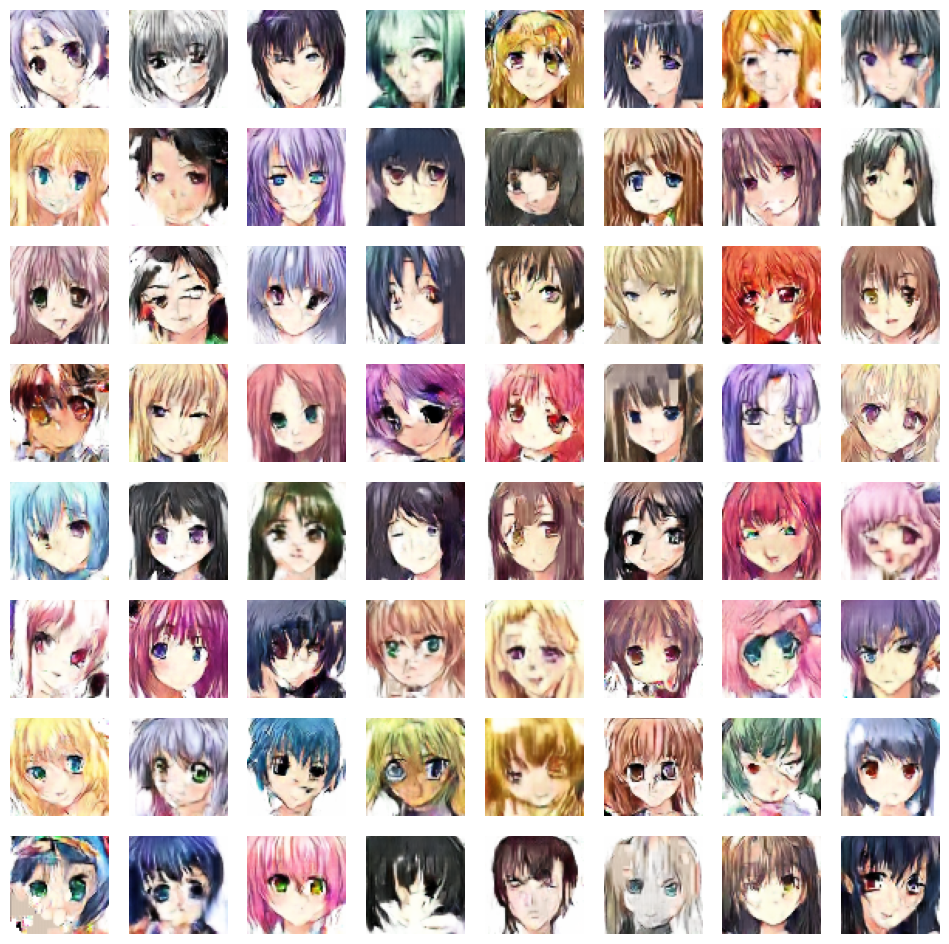

In [45]:
generate_faces()